# NEY-YORK TAXI TIPS - Régression linéaire

Dans cette partie, nous allons implémenter les différents modèles de régressions de notre étude.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
_REP_PATH_ = os.getcwd()

In [3]:
# fonction d'extraction des données vers un fichier .parquet
_REP_OUT_PATH_ = _REP_PATH_ + '/output/'

def export_to_parquet(filename, Y_pred):
    
    reg_df = pd.DataFrame(np.arange(len(Y_pred), dtype = int).T, columns  = ["row_ID"])
    reg_df["tip_amount"] = Y_pred

    reg_df.to_parquet(_REP_OUT_PATH_ + filename)

In [4]:
# Importation des dataframes
train_df = pd.read_csv(_REP_PATH_+'/data/train_nettoye.csv', index_col=0)
test_df = pd.read_csv(_REP_PATH_+'/data/test_nettoye.csv', index_col=0)

train_df

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,dropoff_day,pickup_hour,dropoff_hour,journey_time,pickup_period_encoded
0,1.0,3.30,1.0,0,1,19.1,3.5,0.5,4.80,0.0,...,40.734576,-74.002875,40.768615,-73.965635,15,15,20.616667,20.933333,1155.0,3
1,1.0,0.72,1.0,0,1,5.8,2.5,0.5,2.46,0.0,...,40.768615,-73.965635,40.780436,-73.957012,25,25,19.683333,19.733333,198.0,2
2,2.0,7.45,1.0,0,1,38.7,0.0,0.5,3.00,0.0,...,40.717773,-74.007880,40.780436,-73.957012,25,25,15.800000,16.400000,2135.0,1
3,1.0,1.53,1.0,0,1,10.0,1.0,0.5,2.25,0.0,...,40.720889,-73.996919,40.747746,-73.978492,27,27,0.783333,0.916667,509.0,4
4,1.0,1.53,1.0,0,1,10.0,0.0,0.5,3.50,0.0,...,40.768615,-73.965635,40.747746,-73.978492,28,28,13.233333,13.366667,488.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,4.38,1.0,0,1,26.1,0.0,0.5,3.00,0.0,...,40.768615,-73.965635,40.718938,-73.990896,19,19,9.200000,9.633333,1555.0,0
99996,1.0,5.34,1.0,0,1,25.4,1.0,0.5,6.08,0.0,...,40.748497,-73.992438,40.706808,-74.007496,25,25,0.116667,0.416667,1053.0,4
99997,1.0,10.10,6.0,0,1,35.5,0.0,0.5,0.00,0.0,...,40.857779,-73.885867,40.773633,-73.981532,8,8,9.450000,10.016667,2069.0,0
99998,1.0,5.82,1.0,0,2,36.6,0.0,0.5,0.00,0.0,...,40.780436,-73.957012,40.777427,-73.905407,6,6,18.700000,19.383333,2468.0,2


In [5]:
print(train_df.columns)
print(test_df.columns)

Index(['passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'pickup_day', 'dropoff_day', 'pickup_hour',
       'dropoff_hour', 'journey_time', 'pickup_period_encoded'],
      dtype='object')
Index(['passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
       'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
       'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'pickup_day', 'dropoff_day', 'pickup_hour',
       'dropoff_hour', 'journey_time', 'pickup_period_encoded'],
      dtype='object')


Les deux fichiers ont bien les mêmes features, on peut donc poursuivre notre étude.

## Régression linéaire

Dans notre exploration et synthèse des données, nous avons déjà constaté que la plupart des variables sont directement corrélées avec le montant du pourboire. De même, nous avons analysé l'influence de l'espace et du temps sur le montant du pourboire et découvert que cette variable est fortement affectée par ces facteurs. Cependant, en ce qui concerne l’espace, nous rencontrons le problème de changement de support, où il n’est pas possible d’agréger les points pour prédire le montant des pourboires par zones de New York. La prédiction du montant des pourboires doit être effectuée pour chaque trajet et non par zone. Nous avons déjà dérivé certaines variables comme la durée d'un trajet. 

Puisque l'utilisation d'un modèle spatio-temporel ne semble pas réaliste, et compte tenu de la quantité de données que nous voulons utiliser pour l'entraînement de notre modèle, nous commencerons par un modèle puissant mais simple : une régression linéaire (OLS).

Dans les problèmes de régression, la réponse la plus simple est souvent la bonne. Comme nos données présentent de fortes relations linéaires, une régression OLS pourrait effectivement bien les expliquer. Si une régression OLS ne suffit pas à prédire le montant des pourboires, elle nous permettra au moins d’identifier la signification et l’importance des variables. Cela sera utile pour appliquer d'autres modèles.

### Premier modèle sur le jeu de données sans modification

Ici, nous allons examiner les résultats obtenus par la régression linéaire sur le jeu de données de base. Cela nous permettra d'avoir une Baseline pour la comparaison avec d'autres méthodes plus sophistiquées.

In [6]:
train_df_baseline = pd.read_parquet(_REP_PATH_+'/data/train.parquet')
test_df_baseline = pd.read_parquet(_REP_PATH_+'/data/test.parquet')

train_df_baseline['trip_duration'] = (train_df_baseline['tpep_dropoff_datetime'] - train_df_baseline['tpep_pickup_datetime']).dt.total_seconds()
test_df_baseline['trip_duration'] = (test_df_baseline["tpep_dropoff_datetime"] - test_df_baseline["tpep_pickup_datetime"]).dt.total_seconds() 

In [7]:
# Séléction d'une poignée de features
features = ["congestion_surcharge", "PU_location_lon", "DO_location_lon", "RatecodeID", "payment_type", "trip_distance", "PU_location_lat"]

X_train, X_test, y_train, y_test = train_test_split(train_df_baseline[features], train_df_baseline["tip_amount"], test_size=0.2 , random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 7)
(20000, 7)
(80000,)
(20000,)


In [8]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"Le Score r2 est {r2_score(y_test, y_pred)}")

Le Score r2 est 0.5405869225103033


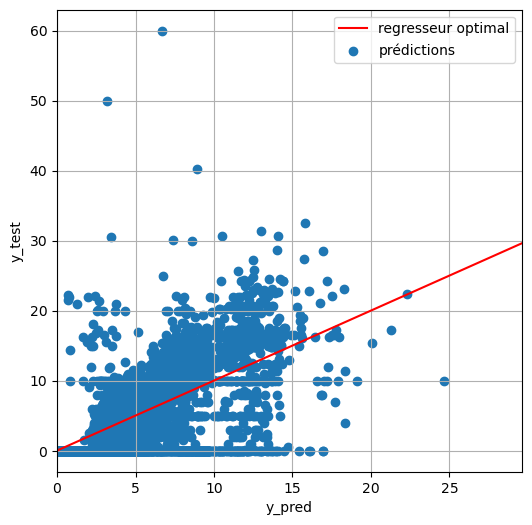

In [9]:
plt.figure(figsize=(6,6))
x = np.linspace(0,max(*y_pred, *y_test))
plt.plot(x,x, color = "red", label = "regresseur optimal")
plt.scatter(y_pred, y_test, label = "prédictions")
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,max(y_pred)+5)
plt.legend()
plt.grid(True)
plt.show()

La méthode de régression linéaire issue du jeu de données initial nous permet d'avoir un score $R^2$ de $0,54$ sur notre jeu de validation, ce qui indique que 54,1 % de la variance de `tip_amount` est expliquée par les variables incluses dans le modèle. Cela montre une relation modérée entre les variables explicatives et `tip_amount`.

 De plus le schéma ci-dessus nous montre la répartition des points $(y\_pred, y\_test)$ pour chaque individus de notre ensemble de validation. Nous représentons en rouge une droite de régression optimal qui à chaque montant de pourboire de l'ensemble de validation est associé le montant de pourboire ($y = x$).

L'on peut remarquer sur ce graphique que :
- Notre `Baseline` associe à la valeur 0 de nombreuses courses qui, en réalité, ont résultés par un pourboire.
- Les valeurs prédites sont relativements concentrées autour de 7$ avec peu d'outliers.

In [10]:
X_test_Sm= sm.add_constant(X_test)
ls=sm.OLS(y_test,X_test_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     3364.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:16:43   Log-Likelihood:                -46404.
No. Observations:               20000   AIC:                         9.282e+04
Df Residuals:                   19992   BIC:                         9.289e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -513.9622 

- La statistique `F` de $3364$, avec une probabilité associée de $0,00$, indique que le modèle dans son ensemble est significatif, c’est-à-dire qu'il existe une relation statistiquement significative entre les variables explicatives et tip_amount.

- L'ensemble des p-valeur associées aux variables sont ptoches de 0, indiquant que les coefficients obtenus sont statistiquement significatifs.

De plus, les coefficients des variables nous permettent de dire :
- `const (intercept)`: La constante est de -513.96. Cela suggère que, sans effet des variables explicatives, la valeur moyenne du pourboire serait théoriquement négative, ce qui n’est pas logique en pratique. Cela peut indiquer la nécessité de revoir certaines hypothèses du modèle ou des données.

De plus, l'ensemble des autres coefficients sont très significatifs (p-valeur proche de 0). Le coefficient associé au type de paiement est négatif, le mode de paiement a une forte influence négative sur le pourboire, peut-être indiquant un biais lié au type de paiement, tandis que `PU_location_lat` à un coefficient de 7.3086, ce qui indique une forte association positive entre la latitude du lieu de prise en charge et le pourboire.

- `Durbin-Watson`: La statistique de Durbin-Watson est proche de 2, indiquant que les résidus sont indépendants (pas de corrélation sérieuse entre eux).
- `Omnibus, Prob(Omnibus), Jarque-Bera (JB)`: Ces tests montrent que les résidus ne suivent pas une distribution normale (p-valeurs très faibles), ce qui peut indiquer des problèmes d’ajustement ou la présence de valeurs extrêmes (forte kurtosis de 31.791).

- `Cond. No (Condition Number)` : À 3.70e+05, le nombre de condition est élevé, ce qui indique une colinéarité parmi les variables explicatives, un potentiel problème pour la stabilité des coefficients.


In [11]:
reg = LinearRegression().fit(train_df_baseline[features], train_df_baseline["tip_amount"])
y_pred = reg.predict(test_df_baseline[features])

export_to_parquet("linear_regression_1.parquet", Y_pred = y_pred)

Après avoir utilisé notre modèle de régression linéaire sur un ensemble de validation, nous l'appliquons à notre ensemble de test. Le score $R^2$ observé sur Kaggle est de $0,57$, montrant une légère amélioration par rapport à l'ensemble de validation.

### Régression linéaire sur notre nouveau jeu de données

Nous examinons maintenant le score obtenu par une régression linéaire sur le nouveau jeu de données obtenu après l'analyse de données.

#### Sélection des features

Ici, nous sélectionnons des features qui semblent intéressantes, d'après l'étude des données, pour une régression linéaire (en excluant certaines variables catégorielles).

In [12]:
# On séléctionne l'ensemble des features sauf "RatecodeID", "store_and_fwd_flag", "payment_type"

reg_train_df = train_df.drop(columns= ["RatecodeID", "store_and_fwd_flag", "payment_type"])
reg_test_df = test_df.drop(columns= ["RatecodeID", "store_and_fwd_flag", "payment_type"])

#### On divise le jeu de données

In [13]:
X = reg_train_df.drop(columns= ["tip_amount"])
y = reg_train_df["tip_amount"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 19)
(20000, 19)
(80000,)
(20000,)


#### Définition du modèle de régression linéaire

In [21]:
from sklearn.feature_selection import SelectKBest, f_regression

# Sélectionne les k meilleures features en fonction de la corrélation
selector = SelectKBest(score_func=f_regression, k=17)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Régression linéaire sur les features sélectionnées
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
score_r2 = r2_score(y_test, y_pred)

print("Score R2 avec SelectKBest :", score_r2)
print("Features sélectionnées :", X.columns[selector.get_support()])

Score R2 avec SelectKBest : 0.4406719269489269
Features sélectionnées : Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'congestion_surcharge', 'Airport_fee',
       'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'dropoff_day', 'pickup_hour', 'dropoff_hour',
       'journey_time', 'pickup_period_encoded'],
      dtype='object')


In [20]:
X_test_Sm= sm.add_constant(X_test_selected)
ls=sm.OLS(y_test,X_test_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     1428.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:19:32   Log-Likelihood:                -48388.
No. Observations:               20000   AIC:                         9.680e+04
Df Residuals:                   19988   BIC:                         9.690e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -774.8918     76.984    -10.066      0.0

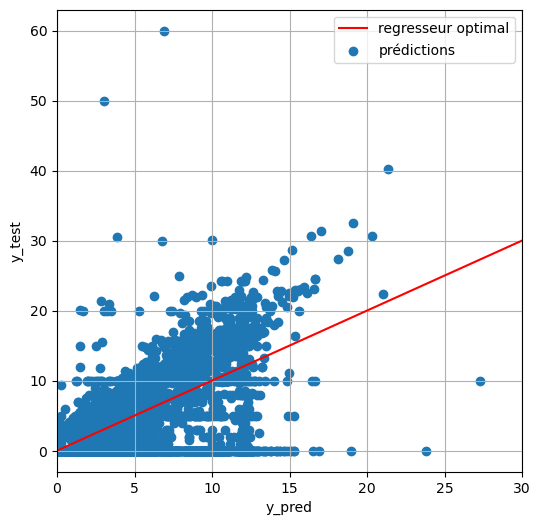

In [22]:
plt.figure(figsize=(6,6))
x = np.linspace(0,max(*y_pred, *y_test))
plt.plot(x,x, color = "red", label = "regresseur optimal")
plt.scatter(y_pred, y_test, label = "prédictions")
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,30)
plt.legend()
plt.grid(True)
plt.show()

On observe une baisse de précision avec notre nouveau jeu de données. En effet, le meilleur score $R^2$ obtenu avec 17 features est de 0,44, soit une perte de 13 points par rapport au dataset avec les données non modifiées.
L'ajout de nouvelles données a donc masqué davantage les relations linéaires entre les variables. Nous avons aussi ajouté de nombreuses données issues de manipulations avec le dataset initial, ce qui a sans doute induit de la multicolinéarité dans nos données.

In [18]:
export_to_parquet("linear_regression_2.parquet", Y_pred = y_pred)

Sur l'ensemble de test, la regression linéaire obtient un score de $0,41$ qui nous confirme la sous performance du modèle contre la `Baseline` issue du dataset de base.